In [ ]:
!pip install simplification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from simplification.cutil import simplify_coords, simplify_coords_vw, simplify_coords_vwp
import urllib.request, json, csv, geopy.distance, os, h5py
from datetime import datetime
from time import sleep, strptime, mktime
from operator import itemgetter
import csv, pickle

apikey = ''

In [2]:
GPS_df = pd.read_hdf('public_transport_warsaw3.h5', key='GPS_df_1', mode='r')
print(GPS_df.shape)
print(GPS_df.columns)
print(GPS_df.dtypes)
# GPS_df.head()

(1160129, 13)
Index(['Lines', 'VehicleNumber', 'Brigade', 'Time', 'Lon', 'Lat', 'res_type',
       'qTime', 'd_time', 'd_dist', 'coord', 'uniqID', 'vehID'],
      dtype='object')
Lines                    object
VehicleNumber            object
Brigade                  object
Time             datetime64[ns]
Lon                     float64
Lat                     float64
res_type                 object
qTime            datetime64[ns]
d_time                    int64
d_dist                  float64
coord                    object
uniqID                   object
vehID                    object
dtype: object


In [3]:
with open('schedule_dict.pickle', 'rb') as fp:
    schedule_dict = pickle.load(fp)

In [5]:
stops_df = pd.read_hdf('public_transport_warsaw.h5', key='stops_df_4', mode='r')
lines_df = pd.read_hdf('public_transport_warsaw.h5', key='lines_df', mode='r')
schedule_df = pd.read_hdf('public_transport_warsaw2.h5', key='schedule_df_2', mode='r')
print(stops_df.shape, lines_df.shape, schedule_df.shape)

(7727, 19) (345, 3) (918719, 13)


In [5]:
print(stops_df.shape)
print(stops_df.columns)
print(stops_df.dtypes)
# stops_df.head(5)

(7727, 19)
Index(['zespol', 'nazwa_zespolu', 'slupek', 'id_ulicy', 'kierunek', 'dlug_geo',
       'szer_geo', 'obowiazuje_od', 'line', 'id_nu', 'no_line', 'changed',
       'error', 'last_change', 'actual', 'deleted', 'dlug_f', 'szer_f',
       'coord'],
      dtype='object')
zespol                   object
nazwa_zespolu            object
slupek                   object
id_ulicy                 object
kierunek                 object
dlug_geo                 object
szer_geo                 object
obowiazuje_od    datetime64[ns]
line                     object
id_nu                    object
no_line                    bool
changed                   int64
error                      bool
last_change      datetime64[ns]
actual                     bool
deleted                    bool
dlug_f                  float64
szer_f                  float64
coord                    object
dtype: object


In [6]:
stop_coords = stops_df[stops_df.actual].set_index('id_nu')[['coord']].to_dict('dict')['coord']

In [7]:
def filter_gps(list_od_tuples, x_limits, y_limits):
    return [x for x in list_od_tuples if coord_check(x, x_limits, y_limits)] # (20.0, 22.0), (51.0, 53.0)
#     return list(filter(lambda x: coord_check(x, x_limits, y_limits), list_od_tuples)) # faster?

def coord_check(to_check, x_limits, y_limits):
    x, y = to_check
    x_min, x_max = x_limits
    y_min, y_max = y_limits
    if((x_min < x < x_max) & (y_min < y < y_max)):
        return True
    else:
        return False
    
def flip(coords):
    return [(y, x) for x, y in coords]   # [x[::-1] for x in coords]

def make_relative(coords): # deprecated
    result = []
    last_first, last_second = coords[0]
    for first, second in coords:
        dist_first = round(geopy.distance.distance((last_second, last_first), (last_second, first)).kilometers, 5)
        dist_second = round(geopy.distance.distance((last_second, last_first), (second, last_first)).kilometers, 5)
        result.append((dist_first, dist_second))
        last_first, last_second = first, second
    return result

In [8]:
def path_dist(to_check_distance):
    sumed = 0.0
    last_first, last_second = to_check_distance[0]
    for first, second in to_check_distance:
        dist = round(geopy.distance.distance((last_second, last_first), (second, first)).kilometers, 5)
        sumed += dist
        last_first, last_second = first, second
    return sumed

In [9]:
def stops_coords_list(line):
    a = lines_df[lines_df.line_nr.isin(line)]['stops'].values[0]
    b = [stop_coords[x] for x in a]
    b = flip(b)          
    b = filter_gps(b, (20.0, 22.0), (51.0, 53.0))
    return b

def draw_stops(b):         
    #b = stops_coords_list(line)
    print('stops nr: ', len(b))
    plt.figure(figsize=(10,6))
    plt.scatter(*zip(*b));

Ramer–Douglas–Peucker or Visvalingam-Whyatt algorithms

In [10]:
def simplify_to_nr(path, nr, tolerance=0, func=simplify_coords, max_iter=100): # simplify_coords_vw
    range_l = 0.0
    range_h = 1.0
    iteration = 1
    while True:
        param = (range_l + range_h)/2
        result = func(path, param)
        result_len = len(result)
        if((result_len >= nr-tolerance) & (result_len <= nr+tolerance)):
            print('Iteration: ', iteration, '      Number: ', result_len, ' Parameter: ', param)
            return result
        elif (result_len < nr): # parameter to high
            range_h = param
            iteration += 1
        else:                      # parameter to low
            range_l = param
            iteration += 1
        if(iteration > max_iter):
            print('calculation to long, Number: ', result_len, ' Parameter: ', param)
            return result  

In [11]:
def draw_simpl_path(line, brig_idx, nr_points, tolerance=0, rdp=True, wv=True):
    brigades = GPS_df[GPS_df.Lines.isin(['122'])].Brigade.value_counts().keys().tolist()
    print(line, brigades)
    line_stops = stops_coords_list([line])
    route = GPS_df[GPS_df.Lines.isin([line]) & 
                   GPS_df.Brigade.isin([brigades[brig_idx]])].sort_values(['Time'])[['Lon', 'Lat']].values
    route = filter_gps(route, (20.0, 22.0), (51.0, 53.0))
    route = np.ascontiguousarray(route)
    simpl_rdp = simplify_to_nr(route, nr_points)
    simpl_vw = simplify_to_nr(route, nr_points, tolerance, func=simplify_coords_vw)
    print(len(line_stops), route.shape, simpl_rdp.shape, simpl_vw.shape)
    print('stops ', path_dist(line_stops), 
          ' gps ', path_dist(route), 
          ' rdp ', path_dist(simpl_rdp), 
          ' wv', path_dist(simpl_vw))
    plt.figure(figsize=(10,6))
    plt.scatter(*zip(*route))
    if(rdp):
        plt.scatter(*zip(*simpl_rdp))
    if(wv):
        plt.scatter(*zip(*simpl_vw))
    plt.show()

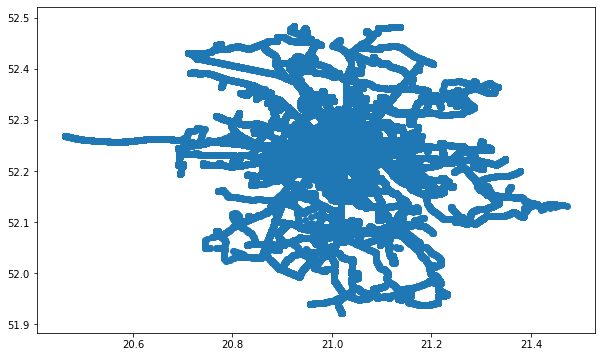

In [191]:
route = GPS_df[['Lon', 'Lat']].values
route = filter_gps(route, (20.0, 22.0), (51.0, 53.0))
plt.figure(figsize=(10,6))
plt.scatter(*zip(*route))
plt.show()

6665


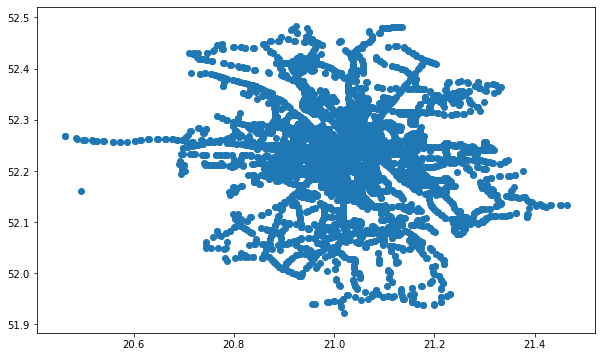

In [221]:
all_stops = stops_df.query('actual').query('~deleted').query('~no_line')['coord'].values
all_stops = flip(all_stops)
all_stops = filter_gps(all_stops, (20.0, 22.0), (51.0, 53.0))
print(len(all_stops))
plt.figure(figsize=(10,6))
plt.scatter(*zip(*all_stops));

stops nr:  75


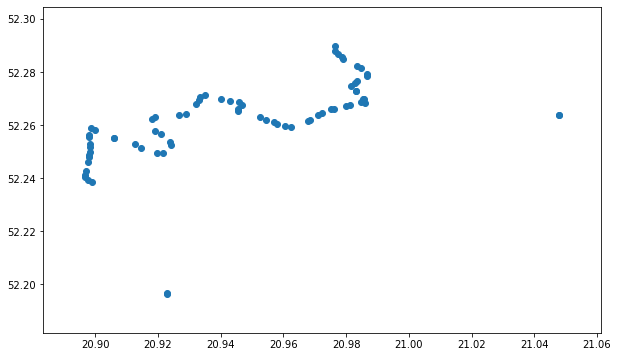

In [103]:
draw_stops(stops_coords_list(['122']))

122 ['4', '8', '1', '2', '5', '9', '6', '7', '3', '062', '011', '010']
calculation to long, Number:  41  Parameter:  0.0025403453873276355
calculation to long, Number:  34  Parameter:  2.5527646130285575e-06
75 (742, 2) (41, 2) (34, 2)
stops  60.718250000000005  gps  49.122970000000024  rdp  46.24679  wv 19.005200000000002


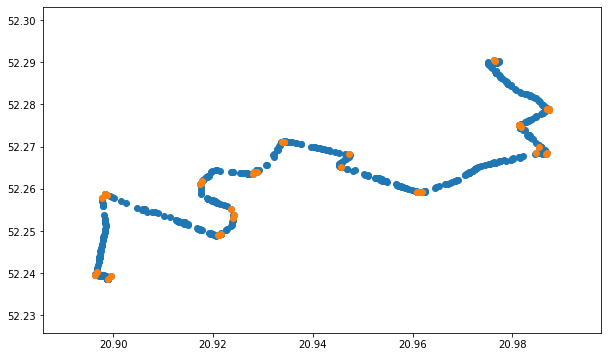

122 ['4', '8', '1', '2', '5', '9', '6', '7', '3', '062', '011', '010']
calculation to long, Number:  41  Parameter:  0.0025403453873276355
calculation to long, Number:  34  Parameter:  2.5527646130285575e-06
75 (742, 2) (41, 2) (34, 2)
stops  60.718250000000005  gps  49.122970000000024  rdp  46.24679  wv 19.005200000000002


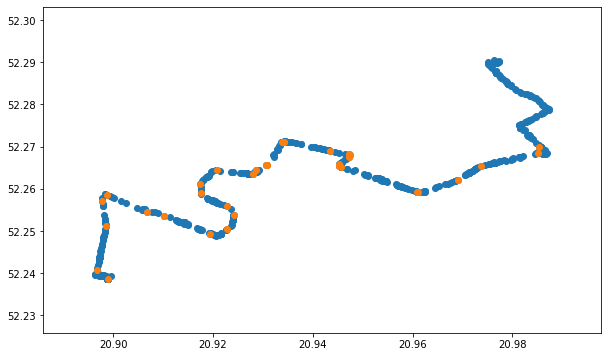

In [16]:
draw_simpl_path('122', 0, 40, rdp=True, wv=False)
draw_simpl_path('122', 0, 40, rdp=False, wv=True)

### GPS suplement

In [60]:
GPS_df[GPS_df.Lines.isin(['129'])].Brigade.value_counts()

3    231
1    204
4    198
2    144
Name: Brigade, dtype: int64

In [55]:
GPS_df[GPS_df.Lines.isin(['195'])].groupby('Brigade')['VehicleNumber'].value_counts()    #.sort_values(ascending=False)

Brigade  VehicleNumber
05       1025             430
1        1071             428
2        1036             800
3        1038             441
4        1064             368
Name: VehicleNumber, dtype: int64

In [38]:
schedule_dict[('122', '4')]

[['5050_08', '05:41:00', 'Gwiaździsta', 'TP-GWI', 0, 0.0, 0.0],
 ['5050_02', '05:42:00', 'Gwiaździsta', 'TP-GWI', 0, 60.0, 0.2326],
 ['5051_02', '05:43:00', 'Gwiaździsta', 'TP-GWI', 0, 120.0, 0.51314],
 ['5052_02', '05:44:00', 'Gwiaździsta', 'TP-GWI', 0, 180.0, 1.08088],
 ['5053_02', '05:45:00', 'Gwiaździsta', 'TP-GWI', 0, 240.0, 1.6191],
 ['5163_02', '05:45:00', 'Gwiaździsta', 'TP-GWI', 0, 240.0, 1.93824],
 ['5054_02', '05:46:00', 'Gwiaździsta', 'TP-GWI', 0, 300.0, 2.65051],
 ['5055_07', '05:47:00', 'Gwiaździsta', 'TP-GWI', 0, 360.0, 2.88631],
 ['5110_01', '05:48:00', 'Gwiaździsta', 'TP-GWI', 0, 420.0, 3.40359],
 ['5063_03', '05:50:00', 'Gwiaździsta', 'TP-GWI', 0, 540.0, 4.12568],
 ['5106_01', '05:52:00', 'Gwiaździsta', 'TP-GWI', 0, 660.0, 4.65462],
 ['5107_01', '05:53:00', 'Gwiaździsta', 'TP-GWI', 0, 720.0, 5.06485],
 ['5064_07', '05:55:00', 'Gwiaździsta', 'TP-GWI', 0, 840.0, 5.72204],
 ['5102_01', '05:56:00', 'Gwiaździsta', 'TP-GWI', 0, 900.0, 6.31435],
 ['5062_01', '05:58:00', 'Gwi

In [149]:
feat = ['Lines', 'Brigade', 'Time', 'coord', 'h_m_s', 'next_stop', 'dist_next', 'prev_stop', 'dist_prev']

In [151]:
GPS_df[GPS_df.Lines.isin(['122'])
      & GPS_df.Brigade.isin(['4'])][feat[3:9]].sort_values('h_m_s')[0:50]

,coord,h_m_s,next_stop,dist_next,prev_stop,dist_prev
517,"(52.238579, 20.898939000000002)",07:27:50,"(71, 5050_08, 07:36:00, 2)",0.00952,"(70, 5050_03, 07:21:00, 1)",0.13145
2161,"(52.238579, 20.898947)",07:28:09,"(71, 5050_08, 07:36:00, 2)",0.01006,"(70, 5050_03, 07:21:00, 1)",0.13184
4628,"(52.238579, 20.898954)",07:28:31,"(71, 5050_08, 07:36:00, 2)",0.01054,"(70, 5050_03, 07:21:00, 1)",0.13218
5948,"(52.238579, 20.898956)",07:28:47,"(71, 5050_08, 07:36:00, 2)",0.01068,"(70, 5050_03, 07:21:00, 1)",0.13227
7224,"(52.238579, 20.89896)",07:28:56,"(71, 5050_08, 07:36:00, 2)",0.01095,"(70, 5050_03, 07:21:00, 1)",0.13247
9717,"(52.238579, 20.898962)",07:29:18,"(71, 5050_08, 07:36:00, 2)",0.01109,"(70, 5050_03, 07:21:00, 1)",0.13257
10955,"(52.238583, 20.898964000000003)",07:29:34,"(71, 5050_08, 07:36:00, 2)",0.01126,"(70, 5050_03, 07:21:00, 1)",0.13235
12287,"(52.238583, 20.898964000000003)",07:29:40,"(71, 5050_08, 07:36:00, 2)",0.01126,"(70, 5050_03, 07:21:00, 1)",0.13235
13672,"(52.238594, 20.898958)",07:29:59,"(71, 5050_08, 07:36:00, 2)",0.01104,"(70, 5050_03, 07:21:00, 1)",0.13121
14974,"(52.238594, 20.89896)",07:30:11,"(71, 5050_08, 07:36:00, 2)",0.01118,"(70, 5050_03, 07:21:00, 1)",0.13131


In [132]:
def find_next_stop(line, brigade, time):
    if (line, brigade) in schedule_dict:
        sched = schedule_dict[(line, brigade)]
    else: return None
    for idx, one in enumerate(sched, 0):
        if one[1] > time:
            return idx, one[0], one[1], one[4]
    return None

def find_prev_stop(line, brigade, next_idx):
    if next_idx <= 0: return None
    if (line, brigade) in schedule_dict:
        sched = schedule_dict[(line, brigade)]
        one = sched[next_idx-1]
        return next_idx-1, one[0], one[1], one[4]
    else: return None

def find_stop_idx(line, brigade, time):
    if (line, brigade) in schedule_dict:
        sched = schedule_dict[(line, brigade)]
    else: return None
    for idx, one in enumerate(sched, 0):
        if one[1] > time:
            return idx, one[0], one[1], one[4]
    return None

def find_stops_by_schedule(line, brigade, time, past=12, future=0):
    sched = schedule_dict[(line, brigade)]
    stop_idx = find_stop_idx(line, brigade, time)[0]
    stops = [(x[0], x[4]) for x in sched[stop_idx-past:stop_idx+future+1]]
    return stops

def dist(coord1, coord2):
    return round(geopy.distance.distance(coord1, coord2).kilometers, 5)

def find_nearest_stop(line, brigade, time, coord):
    stops_to_check = find_stops_by_schedule(line, brigade, time)
    dist_to_stops = [(x, dist(coord, stop_coords[x[0]])) for x in stops_to_check]
    return dist_to_stops
    return min(dist_to_stops, key=lambda x: x[1])

In [44]:
GPS_df['h_m_s'] = GPS_df['Time'].astype(str).str.split().str[1]

In [72]:
%%time
GPS_df['next_stop'] = GPS_df[ ['Lines', 'Brigade', 'h_m_s'] ]\
    .apply(lambda x: (find_next_stop(x['Lines'], x['Brigade'], x['h_m_s'])), axis=1)

Wall time: 1min 13s


In [108]:
GPS_df[GPS_df['next_stop'].isnull()]

,Lines,VehicleNumber,Brigade,Time,Lon,Lat,res_type,qTime,d_time,d_dist,coord,uniqID,vehID,h_m_s,next_stop


In [100]:
GPS_df.dropna(subset=['next_stop'], inplace=True)

In [124]:
x_limits, y_limits = (20.0, 22.0), (51.0, 53.0)

def filter_coord(row):
    y, x = row['coord']
    x_min, x_max = x_limits
    y_min, y_max = y_limits
    if((x_min < x < x_max) & (y_min < y < y_max)):
        return True
    else:
        return False

In [125]:
%%time
GPS_df[~GPS_df.apply(filter_coord, axis=1)]

Wall time: 52.1 s


,Lines,VehicleNumber,Brigade,Time,Lon,Lat,res_type,qTime,d_time,d_dist,coord,uniqID,vehID,h_m_s,next_stop
341997,26,3259,4,2020-02-12 08:21:46,162.943100,145.961840,2,2020-02-12 08:22:02,12,-1.00000,"(145.96184, 162.9431)",26_3259_4_2020-02-12 08:21:46,26_3259_4,08:21:46,"(62, 7047_02, 08:22:00, 1)"
832307,L-8,14435,1,2020-02-12 09:53:28,3161.000000,52.398060,1,2020-02-12 09:53:40,16,6213.40631,"(52.39806, 3161.0)",L-8_14435_1_2020-02-12 09:53:28,L-8_14435_1,09:53:28,"(215, 1800_02, 10:10:00, 7)"
1115879,1,3199,13,2020-02-12 10:45:55,41.281128,18.828493,2,2020-02-12 10:46:14,10,4108.43758,"(18.828492999999998, 41.281128)",1_3199_13_2020-02-12 10:45:55,1_3199_13,10:45:55,"(165, 1006_03, 10:46:00, 5)"


In [126]:
%%time
GPS_df = GPS_df[GPS_df.apply(filter_coord, axis=1)]

Wall time: 24.7 s


In [128]:
%%time
GPS_df['dist_next'] = GPS_df[['coord', 'next_stop']]\
    .apply(lambda x: ( dist(x['coord'], stop_coords[x['next_stop'][1]]) ), axis=1)

Wall time: 4min 1s


In [134]:
%%time
GPS_df['prev_stop'] = GPS_df[ ['Lines', 'Brigade', 'next_stop'] ]\
    .apply(lambda x: (find_prev_stop(x['Lines'], x['Brigade'], x['next_stop'][0])), axis=1)

Wall time: 28.3 s


In [138]:
GPS_df[GPS_df['prev_stop'].isnull()].shape

(2497, 17)

In [141]:
GPS_df.dropna(subset=['prev_stop'], inplace=True)

In [148]:
%%time
GPS_df['dist_prev'] = GPS_df[['coord', 'prev_stop']]\
    .apply(lambda x: ( dist(x['coord'], stop_coords[x['prev_stop'][1]]) ), axis=1)

Wall time: 6min 4s


In [152]:
with open('GPS_df.pickle', 'wb') as fp:
    pickle.dump(GPS_df, fp)

In [ ]:
with open('GPS_df.pickle', 'rb') as fp:
    GPS_df = pickle.load(fp)

In [164]:
find_stops_by_schedule('122', '4', '07:38:04')

['5106_02',
 '5063_04',
 '5110_02',
 '5055_01',
 '5054_01',
 '5053_01',
 '5163_01',
 '5052_01',
 '5051_01',
 '5050_03',
 '5050_08',
 '5050_02',
 '5051_02']

In [171]:
find_nearest_stop('122', '4', '07:38:04', (52.239731, 20.897091))

[(('5106_02', 1), 1.88688),
 (('5063_04', 1), 1.78863),
 (('5110_02', 1), 1.8272),
 (('5055_01', 1), 2.12311),
 (('5054_01', 1), 1.76873),
 (('5053_01', 1), 1.31553),
 (('5163_01', 1), 1.00962),
 (('5052_01', 1), 0.6845),
 (('5051_01', 1), 0.17846),
 (('5050_03', 1), 0.0485),
 (('5050_08', 2), 0.17387),
 (('5050_02', 2), 0.06441),
 (('5051_02', 2), 0.34261)]

stops nr:  12


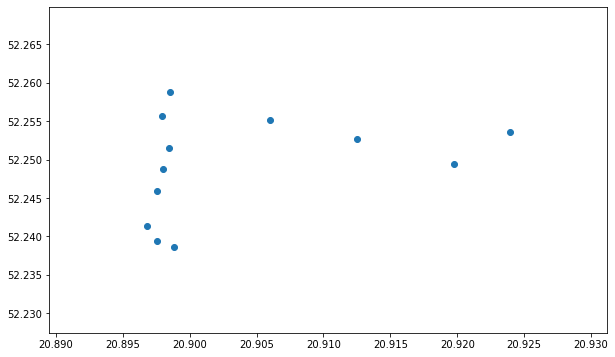

In [151]:
draw_stops(flip([stop_coords[x] for x in find_stops_by_schedule('122', '4', '07:35:11', past=11, future=0)]))

### dataGPS generator

In [ ]:
GPS_columns = ['Lines', 'VehicleNumber', 'Brigade', 'Time', 'Lon', 'Lat',\
               'res_type', 'qTime', 'd_time', 'd_dist', 'coord', 'uniqID', 'vehID']

In [3]:
GPS_resource_id = 'f2e5503e-927d-4ad3-9500-4ab9e55deb59'
resorce_type = ('1', '2')
last_GPS_df = pd.DataFrame([], columns=GPS_columns)
csv_name = 'dataGPS'
csv_nr = 1

def delta_time(vehID, new_time):
    last_time = last_GPS_df[last_GPS_df.vehID == vehID]['Time']
    if (len(last_time)>0):
        try:
            last_time = strptime(last_time.values[0], "%Y-%m-%d %H:%M:%S")
            new_time = strptime(new_time, "%Y-%m-%d %H:%M:%S")
            return int(mktime(new_time) - mktime(last_time))
        except:
            print(last_time, new_time, vehID) 
    return -1

def delta_dist(vehID, new_coord):
    last_coord = last_GPS_df[last_GPS_df.vehID == vehID]['coord']
    if (len(last_coord)>0):
        try:
            return round(geopy.distance.distance(last_coord, new_coord).kilometers, 5)
        except:
            print(last_coord, new_coord, vehID)
    return -1

In [ ]:
while True:
    sleep(5)
    new_GPS_df = pd.DataFrame([], columns=GPS_columns)
    for one in resorce_type:
        api = f'https://api.um.warszawa.pl/api/action/busestrams_get/?apikey={apikey}&type={one}&resource_id={GPS_resource_id}'
        try:
            with urllib.request.urlopen(api) as url:
                dataGPS = json.loads(url.read().decode())['result']
        except:
            print('url error')
            continue
        if(type(dataGPS)==str): #Błędna metoda lub parametry wywołania
            continue
        df = pd.DataFrame(dataGPS, columns=GPS_columns)      
        df['coord'] = df[ ['Lon', 'Lat'] ].apply(lambda x: \
                (pd.to_numeric(x['Lat'], errors='coerce'), pd.to_numeric(x['Lon'], errors='coerce')), axis=1)        
        df['res_type'] = one
        df['qTime'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        df['uniqID'] = df[ ['Lines', 'VehicleNumber', 'Brigade', 'Time'] ]\
            .apply(lambda x: (x['Lines']+'_'+x['VehicleNumber']+'_'+x['Brigade']+'_'+x['Time']), axis=1)
        df['vehID'] = df[ ['Lines', 'VehicleNumber', 'Brigade'] ]\
            .apply(lambda x: (x['Lines']+'_'+x['VehicleNumber']+'_'+x['Brigade']), axis=1)
        new_GPS_df = pd.concat([new_GPS_df, df])
    uniq_items = new_GPS_df[~new_GPS_df.uniqID.isin(last_GPS_df.uniqID)]
    if(len(uniq_items)==0):
        continue
    uniq_items['d_time'] = uniq_items[ ['vehID', 'Time'] ].apply(lambda x: delta_time(x['vehID'], x['Time']), axis=1)
    uniq_items['d_dist'] = uniq_items[ ['vehID', 'coord'] ].apply(lambda x: delta_dist(x['vehID'], x['coord']), axis=1)
    #uniq_items['mean_veloc'] =
    last_GPS_df = pd.concat([last_GPS_df, new_GPS_df])
    last_GPS_df.drop_duplicates(subset=['vehID'], inplace=True, keep='last')
    try:
        with open(csv_name+str(csv_nr)+'.csv', 'a') as f:
            size = os.fstat(f.fileno()).st_size
            print(uniq_items.shape, last_GPS_df.shape, new_GPS_df.shape, size)
            if(size>100000000): csv_nr += 1
        with open(csv_name+str(csv_nr)+'.csv', 'a') as f:
            uniq_items.iloc[:,0:10].to_csv(f, header=False, index=False, sep=',')        
    except:
        print('file error')

In [4]:
GPS_df = pd.read_csv('dataGPS1.csv', names=GPS_columns, dtype=str)

In [5]:
GPS_df['coord'] = GPS_df[ ['Lon', 'Lat'] ].apply(lambda x:\
    (pd.to_numeric(x['Lat'], errors='coerce'), pd.to_numeric(x['Lon'], errors='coerce')), axis=1)
GPS_df['uniqID'] = GPS_df[ ['Lines', 'VehicleNumber', 'Brigade', 'Time'] ]\
    .apply(lambda x: (x['Lines']+'_'+x['VehicleNumber']+'_'+x['Brigade']+'_'+x['Time']), axis=1)
GPS_df['vehID'] = GPS_df[ ['Lines', 'VehicleNumber', 'Brigade'] ]\
    .apply(lambda x: (x['Lines']+'_'+x['VehicleNumber']+'_'+x['Brigade']), axis=1)
GPS_df['Time'] = pd.to_datetime(GPS_df['Time'])
GPS_df['qTime'] = pd.to_datetime(GPS_df['qTime'])
GPS_df['Lon'] = pd.to_numeric(GPS_df['Lon'], errors='coerce')
GPS_df['Lat'] = pd.to_numeric(GPS_df['Lat'], errors='coerce')
GPS_df['d_time'] = pd.to_numeric(GPS_df['d_time'], errors='coerce')
GPS_df['d_dist'] = pd.to_numeric(GPS_df['d_dist'], errors='coerce')

In [ ]:
GPS_df.to_hdf('public_transport_warsaw3.h5', key='GPS_df_1')

In [21]:
GPS_df[GPS_df.Lines.isin(['122'])].shape

(6169, 13)

In [ ]:
GPS_df[GPS_df.Lines.isin(['122'])].VehicleNumber.value_counts()

In [ ]:
GPS_df[GPS_df.Lines.isin(['122'])].Brigade.value_counts()

In [ ]:
GPS_df[GPS_df.Lines.isin(['122'])].min()

In [ ]:
GPS_df[GPS_df.Lines.isin(['122'])].max()

In [36]:
GPS_df[GPS_df.Lines.isin(['122'])
      & GPS_df.VehicleNumber.isin(['1405'])].shape

(581, 13)

In [80]:
GPS_df[GPS_df.Lines.isin(['122'])
      & GPS_df.VehicleNumber.isin(['1405'])].Brigade.value_counts()

5    581
Name: Brigade, dtype: int64

In [45]:
GPS_df[GPS_df.Lines.isin(['122'])].max()['qTime'] - GPS_df[GPS_df.Lines.isin(['122'])].min()['qTime']

Timedelta('0 days 03:26:41')

In [ ]:
route = GPS_df[GPS_df.Lines.isin(['122'])][['Lon', 'Lat']].values
route=np.ascontiguousarray(route)
print(route.flags)
route.shape

In [222]:
# podaje min i max wartości w liście krotek
check = route

print('1', min(check, key=lambda item:item[0])[0], max(check, key=lambda item:item[0])[0])
print('2', min(check, key=lambda item:item[1])[1], max(check, key=lambda item:item[1])[1])
print()
print('1', min(check, key=itemgetter(0))[0], max(check, key=itemgetter(0))[0]) 
print('2', min(check, key=itemgetter(1))[1], max(check, key=itemgetter(1))[1])

1 20.894287 21.039823300000002
2 52.196487 52.29272329999999

1 20.894287 21.039823300000002
2 52.196487 52.29272329999999
